**<font size="15">Introduction</font>**

The following dataset comes from the Texas Justice Initiative, and covers all deaths in Texas custody since 2005.  After cleaning the data, we're going to use information from the dataset to build a model that will hopefully explain 'manner_of_death', i.e. the stated reason why people died in custody: natural causes/illness, homicide, suicide, alcohol/drug intoxication, accidentally, or other.

The Texas Justice Initiative can be found online at https://texasjusticeinitiative.org/.  The TJI actually collects data in three general areas: deaths in custody, civilians shot, and officers shot.  A separate dataset is provided for each.  As stated above, we are going to focus on just the deaths in custody dataset.

The full description of the TJI's data collection efforts is copy-pasted below:

*Increasing transparency in the criminal justice system is of vital importance to us at the Texas Justice Initiative. Our work relies on the use of information that can be released to the public.*

*Currently on our website, we compile data about three main incident types that occur in Texas:*

*Injury of officer(s) and/or civilian(s): Any shooting of or by a Texas peace officer, occurring while the officer is on- or off-duty, causing an injury.*

*Death of officer(s) and/or civilian(s): Any fatal shooting of or by a Texas peace officer, occurring while the officer is on- or off-duty.*

*Death in custody: Any death of an individual while they are in a penal institution, in the custody of a peace officer or as a result of a peace officer’s use of force, in a jail, correctional facility, or state juvenile facility dies.*

*After an incident, the governmental agency in which it occurred (i.e. a county jail etc.) is required to file a report for the respective incident (1, 2, 3) with the Texas Office of the Attorney General (OAG) within 30 days.*

*The Texas OAG publishes the raw .PDFs of these reports. Through open records requests filed monthly, TJI obtains data from the reports through the Texas OAG.*

*We then clean, analyze, and present the data to the public – both in the form of a full data set and in comparative graphics – through our analysis pipeline.*

*Our analysis pipeline is summarized below. The scripts we use in the analysis pipeline can be found on our GitHub page.*


In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

from statsmodels.graphics.gofplots import qqplot

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import time
import datetime as dt


%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 300)
pd.set_option('max_colwidth', 400)

**<font size="10">First Look At The Data</font>**

In [3]:
df = pd.read_csv('tji_custodialDeaths.csv', sep=',')
df.head()

record_id  num_revisions form_version          report_date  \
0   PA16489PF            0.0       V_2005  2016-10-25 13:05:00   
1    PA15069C            0.0       V_2005  2015-02-19 09:51:00   
2   PA06004CJ            0.0       V_2005  2006-02-16 15:26:00   
3  19-1004-MJ            0.0       V_2016  2019-10-04 13:54:00   
4    19-944-P            0.0       V_2016  2019-09-24 11:39:00   

  date_time_of_custody_or_incident name_first       name_last name_middle  \
0              2016-01-28 20:01:00     JOSHUA  TOYIN OLUBUNMI         NaN   
1              2015-02-03 11:45:00     WILBER         GONGORA    CASTILLO   
2              2004-01-11 12:00:00      RUBEN     BLANCO-POTT     ALBERTO   
3              2019-09-26 02:29:00       AXEL       GUTIERREZ       HIRAM   
4              2010-05-12 00:00:00    DOUGLAS           BOEHM         RAY   

  name_suffix                  name_full        date_of_birth  \
0         NaN      JOSHUA TOYIN OLUBUNMI  1962-06-01 00:00:00   
1         NaN    WILBER CASTILLO GONGORA  1980-01-09 00:00:00   
2         NaN  RUBEN ALBERTO BLANCO-POTT  1968-05-07 00:00:00   
3         NaN       AXEL HIRAM GUTIERREZ  1991-12-03 00:00:00   
4         NaN          DOUGLAS RAY BOEHM  1960-01-27 00:00:00   

   age_at_time_of_death     sex      race           death_date  \
0                  54.0  FEMALE     OTHER  2016-10-24 00:00:00   
1                  35.0    MALE  HISPANIC  2015-02-04 00:00:00   
2                  37.0    MALE     OTHER  2006-01-05 00:00:00   
3                  27.0    MALE  HISPANIC  2019-09-26 00:00:00   
4                  59.0    MALE     WHITE  2019-09-14 00:00:00   

   death_date_and_time death_location_county death_location_city  \
0  2016-10-24 23:18:00               HASKELL             HASKELL   
1  2015-02-04 19:42:00               WICHITA             ELECTRA   
2  2006-01-05 02:45:00                KARNES         KARNES CITY   
3  2019-09-26 04:03:00               CAMERON         PORT ISABEL   
4  2019-09-14 17:59:00              ANDERSON    TENNESSEE COLONY   

  death_location_street_address       death_location_type  \
0                    1 AVENUE N          MEDICAL FACILITY   
1     U.S. 287 @ U.S. 287 BUS H          MEDICAL FACILITY   
2              810 COMMERCE ST.          MEDICAL FACILITY   
3               110. W. HICKMAN  LAW ENFORCEMENT FACILITY   
4                  2664 FM 2054  LAW ENFORCEMENT FACILITY   

  death_location_type_other death_from_pre_existing_medical_condition  \
0                       NaN                                   UNKNOWN   
1                       NaN                                   UNKNOWN   
2                       NaN                                       YES   
3                       NaN                            NOT APPLICABLE   
4                       NaN                                   UNKNOWN   

          manner_of_death               manner_of_death_description  \
0  NATURAL CAUSES/ILLNESS                                   PENDING   
1          OTHER, SPECIFY  RULED NOT DETERMINED BY MEDICAL EXAMINER   
2  NATURAL CAUSES/ILLNESS            AIDS SYNDROME / URINARY SEPSIS   
3                 SUICIDE                                       NaN   
4  NATURAL CAUSES/ILLNESS                                       NaN   

           means_of_death means_of_death_other  \
0          NOT APPLICABLE                  NaN   
1          OTHER, SPECIFY              UNKNOWN   
2          NOT APPLICABLE                  NaN   
3  HANGING, STRANGULATION                  NaN   
4          NOT APPLICABLE                  NaN   

                                                       medical_cause_of_death  \
0                                                             AUTOPSY PENDING   
1  HYPERTENSIVE HEART DISEASE WITH METHAMPHETMAINE INTOXICATION AND RESTRAINT   
2                                              AIDS SYNDROME / URINARY SEPSIS   
3                               MALE SUBJECT USED OWN SHIRT AND HUNG HIMSELF.   
4       



**<font size="10">Data Cleaning</font>**


Let's first look at a visualization of all the missing values in the dataset.  As can be seen below, it looks a little hairy.

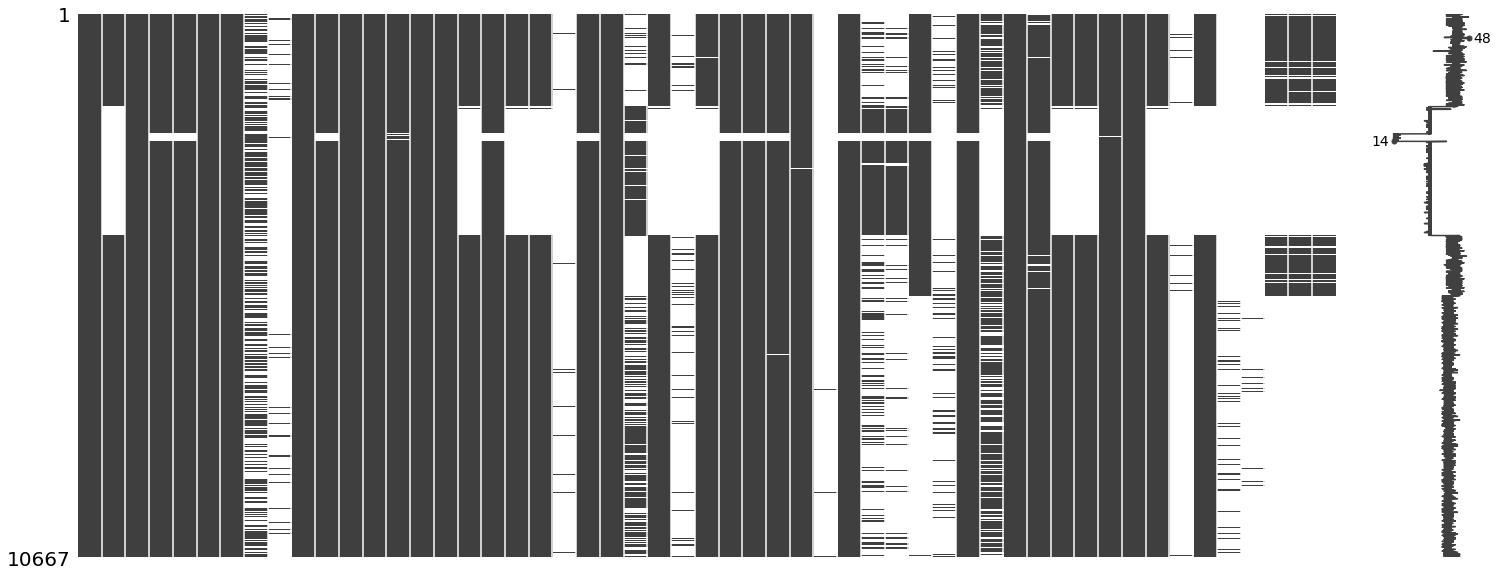

In [4]:
msno.matrix(df)
plt.show()

Next, let's create a ranked list of missing values by column (assuming any were missing in the first place).

In [5]:
missing_df = round(df.isnull().sum().sort_values(ascending=False)/len(df)*100,2)
missing_df[missing_df > 0]

who_caused_death_in_homicide_or_accident_other    99.56
death_location_type_other                         98.58
other_behavior                                    98.36
type_of_restraint                                 98.07
name_suffix                                       94.94
entry_behavior                                    93.20
means_of_death_other                              92.80
type_of_offense_other                             89.59
exhibit_any_mental_health_problems                74.42
make_suicidal_statements                          74.41
exhibit_any_medical_problems                      74.14
offense_3                                         71.49
offense_2                                         57.96
type_of_offense                                   49.30
manner_of_death_description                       47.01
name_middle                                       44.40
facility_entry_date_time                          44.10
under_restraint                                 

Here is the basic info for the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10667 entries, 0 to 10666
Data columns (total 53 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   record_id                                       10667 non-null  object 
 1   num_revisions                                   8136 non-null   float64
 2   form_version                                    10667 non-null  object 
 3   report_date                                     10520 non-null  object 
 4   date_time_of_custody_or_incident                10516 non-null  object 
 5   name_first                                      10667 non-null  object 
 6   name_last                                       10667 non-null  object 
 7   name_middle                                     5931 non-null   object 
 8   name_suffix                                     540 non-null    object 
 9   name_full                              

Now we're ready to drop all columns in the dataset that were either not useful due to having too many missing values, had too many unique values to be workable as (categorical) features, were flat-out not relevant to the question at hand, overlapped too much with another column (or more) to be useful by themselves, or were of interest, but only for future, more targeted analyses.

**Too many missing values:**

'death_location_type_other',

'death_from_pre_existing_medical_condition',

'manner_of_death_description',

'means_of_death',

'who_caused_death_in_homicide_or_accident',

'who_caused_death_in_homicide_or_accident_other',

'type_of_offense',

'type_of_offense_other',

'facility_entry_date_time',

'type_of_restraint',

'entry_behavior',

'other_behavior',

'exhibit_any_medical_problems',

'exhibit_any_mental_health_problems',

'make_suicidal_statements'

**Too many unique values to be workable:**

'death_location_county',

'death_location_city',

'death_location_street_address',

'means_of_death_other',

'medical_cause_of_death',

'offense_1',

'offense_2',

'offense_3',

'agency_city',

'agency_county',

'agency_name'

**Not relevant to the question at hand:**


'record_id',

'num_revisions',

'form_version',

'report_date', 

'name_first',

'name_last',

'name_middle',

'name_suffix',

'name_full',

'agency_address',

'agency_zip',

**Overlapped too much with another column:**
            
'medical_treatment',


**Interesting, but covered only a small subclass of the data.  Merits investigation in the future.**

'who_caused_death_in_homicide_or_accident',


In [7]:
drop_col_list = ['record_id',
            'num_revisions',
            'form_version',
            'report_date', 
            'name_first',
            'name_last',
            'name_middle',
            'name_suffix',
            'name_full',
            'death_location_county',
            'death_location_city',
            'death_location_street_address',
            'death_location_type_other',
            'death_from_pre_existing_medical_condition',
            'manner_of_death_description',
            'means_of_death',
            'means_of_death_other',
            'medical_cause_of_death',
            'medical_treatment',
            'who_caused_death_in_homicide_or_accident',
            'who_caused_death_in_homicide_or_accident_other',
            'offense_2',
            'offense_3',
            'type_of_offense',
            'type_of_offense_other',
            'facility_entry_date_time',
            'agency_address',
            'agency_city',
            'agency_county',
            'agency_name',
            'agency_zip',
            'type_of_restraint',
            'entry_behavior',
            'other_behavior',
            'exhibit_any_medical_problems',
            'exhibit_any_mental_health_problems',
            'make_suicidal_statements']

df = df.drop(drop_col_list, axis=1)

df['under_restraint'] = np.where((df['under_restraint'] == 'YES, MARK WHICH RESTRAINT DEVICES WERE USED') | 
                                 (df['under_restraint'] == 'YES'), 'YES', 'NO')

df.head()

date_time_of_custody_or_incident        date_of_birth  age_at_time_of_death  \
0              2016-01-28 20:01:00  1962-06-01 00:00:00                  54.0   
1              2015-02-03 11:45:00  1980-01-09 00:00:00                  35.0   
2              2004-01-11 12:00:00  1968-05-07 00:00:00                  37.0   
3              2019-09-26 02:29:00  1991-12-03 00:00:00                  27.0   
4              2010-05-12 00:00:00  1960-01-27 00:00:00                  59.0   

      sex      race           death_date  death_date_and_time  \
0  FEMALE     OTHER  2016-10-24 00:00:00  2016-10-24 23:18:00   
1    MALE  HISPANIC  2015-02-04 00:00:00  2015-02-04 19:42:00   
2    MALE     OTHER  2006-01-05 00:00:00  2006-01-05 02:45:00   
3    MALE  HISPANIC  2019-09-26 00:00:00  2019-09-26 04:03:00   
4    MALE     WHITE  2019-09-14 00:00:00  2019-09-14 17:59:00   

        death_location_type         manner_of_death  \
0          MEDICAL FACILITY  NATURAL CAUSES/ILLNESS   
1          MEDICAL FACILITY          OTHER, SPECIFY   
2          MEDICAL FACILITY  NATURAL CAUSES/ILLNESS   
3  LAW ENFORCEMENT FACILITY                 SUICIDE   
4  LAW ENFORCEMENT FACILITY  NATURAL CAUSES/ILLNESS   

  medical_examinor_coroner_evalution  days_from_custody_to_death  \
0                                 NO                       270.0   
1                                YES                         1.0   
2                                 NO                       724.0   
3                                YES                         0.0   
4                                 NO                      3412.0   

                                             offense_1  \
0                                           FAIL TO ID   
1                             EVADING ARREST/DETENTION   
2                                      ILLEGAL REENTRY   
3  DRIVING WHILE INTOXICATED 49.04 CLASS B MISDEMEANOR   
4                            AGGRAVATED SEXUAL ASSAULT   

             were_the_charges               type_of_custody  \
0                   CONVICTED              PRIVATE FACILITY   
1  NOT FILED AT TIME OF DEATH  POLICE CUSTODY (PRE-BOOKING)   
2                   CONVICTED                 JAIL - COUNTY   
3  NOT FILED AT TIME OF DEATH              JAIL - MUNICIPAL   
4                   CONVICTED                        PRISON   

                            specific_type_of_custody_facility under_restraint  
0                                                       OTHER              NO  
1  CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST             YES  
2                                          HOSPITAL/INFIRMARY              NO  
3                                         JAIL - HOLDING CELL              NO  
4                                                        TDCJ              NO

Next, we're going to drop nulls from all "essential columns" -- i.e. columns that are sufficiently important for what we're trying to explain ('manner_of_death') that also do not have too many missing values to be unworkable (see the list above).

In [8]:
df = df.dropna(subset=['date_of_birth',
                       'age_at_time_of_death',
                       'race',
                       'death_date',
                       'death_date_and_time',
                       'death_location_type',
                       'date_time_of_custody_or_incident',
                       'days_from_custody_to_death',
                       'medical_examinor_coroner_evalution',
                       'were_the_charges',
                       'specific_type_of_custody_facility',
                       'under_restraint'], how='any')

print('There are', df.shape[0], 'observations left after this initial purge.')

There are 7970 observations left after this initial purge.


Let's check to make sure the date values in 'death_date' and 'death_date_and_time' aren't different than one another.

In [9]:
df['death_date'] = pd.to_datetime(df['death_date']).dt.date
df['conv_death_date_and_time'] = pd.to_datetime(df['death_date_and_time']).dt.date

print(df[df['death_date'] != df['conv_death_date_and_time']].shape[0])

df = df.drop(['conv_death_date_and_time'], axis=1)

0


Luckily, the above proves that the date values in the 'death_date' and 'death_date_and_time' columns are not different, which is nice.

Next, we're going to run a basic date check. We're going to insist just that 'date_of_custody_or_incident' occurs after 
'date_of_birth' and also that 'death_date' occurs after 'date_of_birth'.

In [10]:
df['date_of_custody_or_incident'] = pd.to_datetime(df['date_time_of_custody_or_incident']).dt.date
df = df.drop(['date_time_of_custody_or_incident'], axis=1)

df['date_of_birth'] = pd.to_datetime(df['date_of_birth']).dt.date

basic_date_check = df[(df['date_of_custody_or_incident'] > df['date_of_birth']) & (df['death_date'] > df['date_of_birth'])]
basic_date_check.shape[0]

7857

So, it looks like there are 113 observations (out of the 7970 left after the initial purge) that fail the basic date check.  We'll remove those.

In [11]:
df = basic_date_check
df.shape[0]

7857

Next, just for the heck of it, we're going to create a variable called 'percent_life_incarcerated'.

In [12]:
df['days_lived'] = df['death_date'].sub(df['date_of_birth'], axis=0)
df['days_lived'] = df['days_lived'] / np.timedelta64(1, 'D')

df['days_lived'] = df['days_lived'].astype('int64')
df['age_at_time_of_death'] = df['age_at_time_of_death'].astype('int64')
df['days_from_custody_to_death'] = df['days_from_custody_to_death'].astype('int64')


df['percent_life_incarcerated'] = df['days_from_custody_to_death']/df['days_lived']

Next, let's run a basic check on the 'percent_life_incarcerated' feature we just made.  We're going to see if any percentages below 0% or above 100% occurred, which would definitely suggest a problem with other columns.

In [13]:
percent_check = df[(df['percent_life_incarcerated'] >= 1) | (df['percent_life_incarcerated'] < 0)]

percent_check.shape[0]

0

Nothing out of the ordinary here, but since the 'percent_life_incarcerated' calculation relied upon a calculated 'days_lived' variable, let's run a check to make sure that a manual calculation of 'days_from_custody_to_death' is not too far off (1 day or less) than the actual column.

In [14]:
df['calc_days_from_custody_to_death'] = df['death_date'].sub(df['date_of_custody_or_incident'], axis=0)
df['calc_days_from_custody_to_death'] = (df['calc_days_from_custody_to_death'] / np.timedelta64(1, 'D')).astype('int64')

days_lived_check = df['calc_days_from_custody_to_death'].sub(df['days_from_custody_to_death'], axis=0)
df[abs(days_lived_check) > 1].shape[0]

0

Next, let's check to make sure that the 'age_at_time_of_death' column actually agrees with a manual age calculation based on 'date_of_birth' and 'death_date' in the dataset.

In [15]:
df = df[df['age_at_time_of_death'] > 0]

df['years_lived'] = df['death_date'].sub(df['date_of_birth'], axis=0)
df['years_lived'] = df['years_lived'] / np.timedelta64(1, 'Y')
df['years_lived'] = df['years_lived'].astype('int64')

df[['date_of_birth',
    'death_date',
    'age_at_time_of_death',
    'years_lived']][df['age_at_time_of_death'] != df['years_lived']]

<ipython-input-15-e0ad17f3822e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['years_lived'] = df['death_date'].sub(df['date_of_birth'], axis=0)
<ipython-input-15-e0ad17f3822e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['years_lived'] = df['years_lived'] / np.timedelta64(1, 'Y')
<ipython-input-15-e0ad17f3822e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

date_of_birth  death_date  age_at_time_of_death  years_lived
219     1968-08-14  2019-08-14                    51           50
5172    1994-04-19  2019-04-19                    25           24
6339    1980-07-10  2007-07-10                    27           26
6596    1967-03-20  2008-03-19                    40           41
7420    1956-12-17  2010-12-17                    54           53
7560    1978-03-25  2011-03-25                    33           32
7690    1984-09-23  2011-09-23                    27           26
8785    1944-01-09  2014-01-08                    69           70
9085    1972-05-30  2014-05-30                    42           41

The above shows that -- once we made sure all values for 'age_at_time_of_death' had to be above 0 -- the 'age_at_time_of_death' variable is actually better than our calculated 'years_lived' variable. The only observations wherein the two recorded different values occurred in "birthday situations".  And in those situations, 'age_at_time_of_death' was in fact correct.

*Note: earlier data ecploration did show there to be two unborn children in this dataset.  The above 'age_at_time_of_death' > 0 cutoff eliminates them.  This is justified, as we are focused on individuals who are allegedly criminals.*

In Texas, you can be tried as an adult starting at age 15.  Let's see what the observations for people who supposedly died in custody at age 14 or younger look like.

In [16]:
under_14 = df[['date_of_custody_or_incident',
    'date_of_birth',
    'age_at_time_of_death',
    'death_date',
    'offense_1',
    'were_the_charges',
    'specific_type_of_custody_facility']][df['age_at_time_of_death'].between(1,14,inclusive=True)]
under_14

date_of_custody_or_incident date_of_birth  age_at_time_of_death  \
1340                  2017-05-19    2004-03-09                    13   
6826                  2007-12-20    2007-11-29                     1   
6895                  2008-05-21    1994-10-26                    14   
6964                  2008-03-06    1997-12-12                    11   
7393                  2010-08-24    1998-10-09                    11   
7500                  2008-04-18    1998-05-01                    12   
7708                  2011-09-28    1997-05-09                    14   
7775                  2012-01-16    1997-10-07                    14   
8125                  2013-01-01    2000-01-14                    12   

      death_date                                               offense_1  \
1340  2017-05-31                                  INDECENCY WITH A CHILD   
6826  2008-12-12                                        ILLEGAL RE-ENTRY   
6895  2009-03-16  INJURY TO A CHILD/ELDERLY/DISABLED W/INT BODILY INJURY   
6964  2009-06-25                                                     DWI   
7393  2010-08-24                     UNAUTHORIZED USE OF A MOTOR VEHICLE   
7500  2011-03-02                                                 ROBBERY   
7708  2011-10-16                 AGGREVATED ASSAULT WITH A DEADLY WEAPON   
7775  2012-01-16                 EVADING ARREST/DETENTION: USING VEHICLE   
8125  2013-01-01                                       EVADING DETENTION   

                were_the_charges  \
1340                   CONVICTED   
6826                   CONVICTED   
6895                   CONVICTED   
6964                   CONVICTED   
7393  NOT FILED AT TIME OF DEATH   
7500                   CONVICTED   
7708                       FILED   
7775  NOT FILED AT TIME OF DEATH   
8125  NOT FILED AT TIME OF DEATH   

                               specific_type_of_custody_facility  
1340                                                       OTHER  
6826                                                       OTHER  
6895                                          JAIL - SINGLE CELL  
6964                                                        TDCJ  
7393  CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST  
7500                                                        TDCJ  
7708                                                       OTHER  
7775  CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST  
8125  CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST

Manual inspection shows that some of these observations may make sense, but it's hard to say. Therefore, I'm going to be safe and remove anyone from the dataset that died before age 15.

In [17]:
df = df[df['age_at_time_of_death'] >= 15]
print('There are', df.shape[0],'observations left after this purge')

There are 7839 observations left after this purge


Just in case some of the 'date_of_custody_or_incident' dates are off (some of them are, actually), let's only accept observations whererin the recorded 'date_of_custody_or_incident' is 15 years or more from the recorded 'date_of_birth'.

In [18]:
df = df[(df['date_of_custody_or_incident'].sub(df['date_of_birth']) / np.timedelta64(1, 'D')).astype('int64') >= 5475]
df.shape[0]

7836

Our basic checks done, let's drop the unneccessary columns and proceed with the analysis.

In [19]:
df = df.drop(['death_date',
              'death_date_and_time',
              'date_of_birth',
              'calc_days_from_custody_to_death',
              'date_of_custody_or_incident',
              'days_lived',
              'offense_1',
              'years_lived'], axis=1)

**<font size="10">Data Exploration</font>**

These are our new columns.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7836 entries, 0 to 10663
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age_at_time_of_death                7836 non-null   int64  
 1   sex                                 7836 non-null   object 
 2   race                                7836 non-null   object 
 3   death_location_type                 7836 non-null   object 
 4   manner_of_death                     7836 non-null   object 
 5   medical_examinor_coroner_evalution  7836 non-null   object 
 6   days_from_custody_to_death          7836 non-null   int64  
 7   were_the_charges                    7836 non-null   object 
 8   type_of_custody                     7836 non-null   object 
 9   specific_type_of_custody_facility   7836 non-null   object 
 10  under_restraint                     7836 non-null   object 
 11  percent_life_incarcerated           7836 n

We have no missing values, hooray!

In [21]:
missing_df = round(df.isnull().sum().sort_values(ascending=False)/len(df)*100,2)
missing_df[missing_df > 0]

Series([], dtype: float64)

Compare the below visualization to the above to get an idea of how much we cleaned the dataset in the interim.

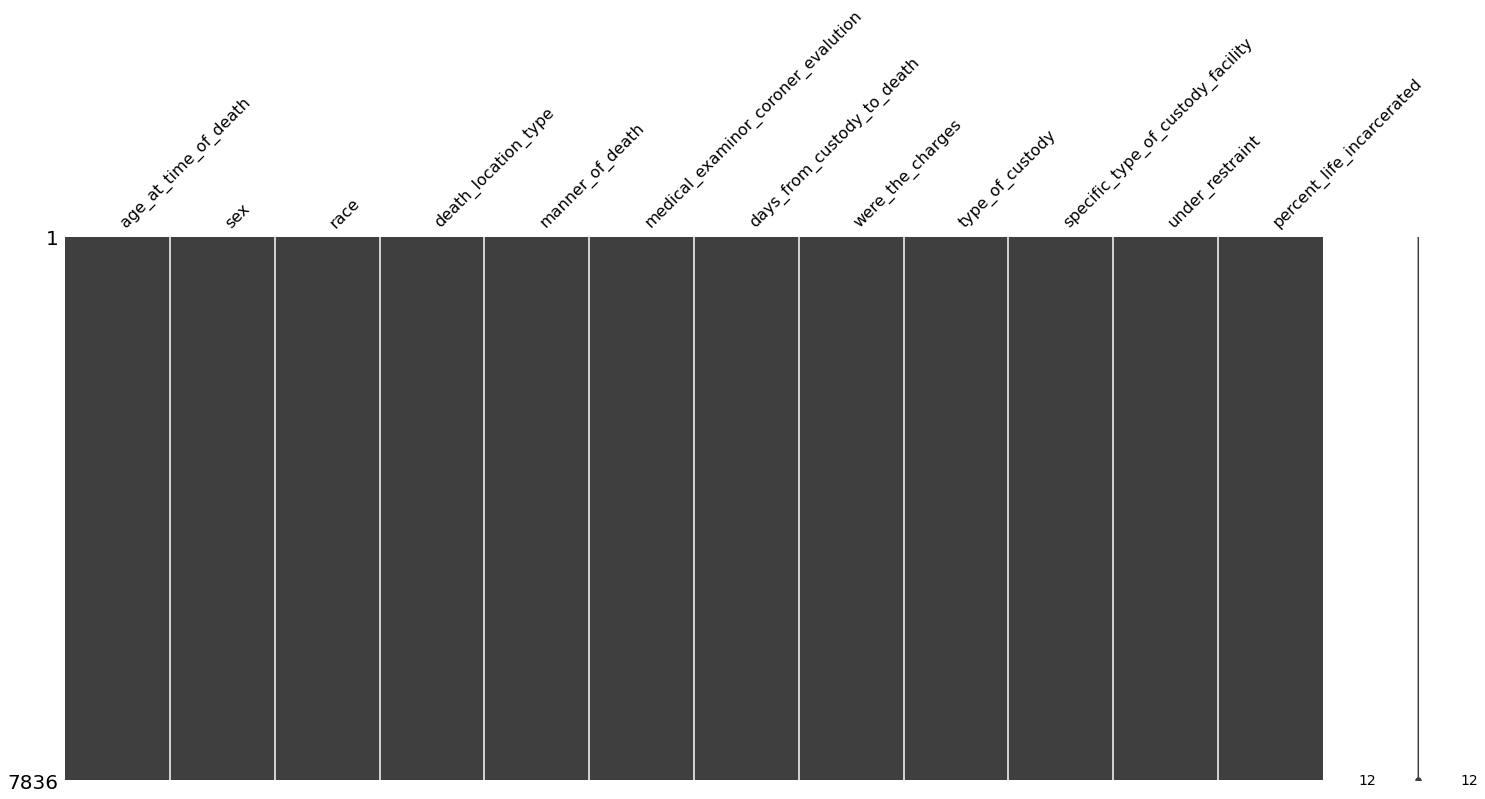

In [22]:
msno.matrix(df)
plt.show()

Let's take a look at the distribution of 'age_at_time_of_death'....

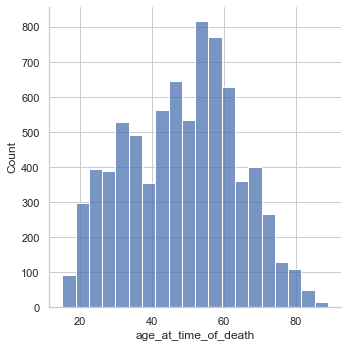

DescribeResult(nobs=7836, minmax=(15, 89), mean=48.171388463501785, variance=240.18644866541382, skewness=-0.03598243346824439, kurtosis=-0.7769791977613729)


In [23]:
sns.set_theme(style='whitegrid')
sns.displot(df['age_at_time_of_death'], bins=20)
plt.show()
print(stats.describe(df['age_at_time_of_death']))

The visualization and the descriptive statistics reveal a (relatively) normal distribution, which is good, and expected.  Obviously the average 'age_at_time_of_death' is going to be way lower than in the general population.

Next, let's take a look at 'days_from_custody_to_death'

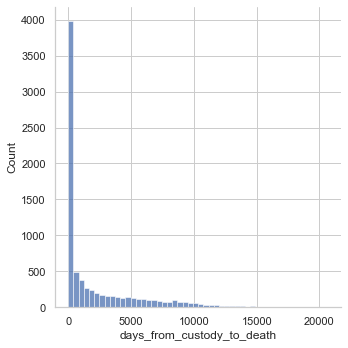

In [24]:
sns.displot(df['days_from_custody_to_death'], bins=50)
plt.show()

This looks like a highly right-skewed Poisson distribution.  The fact that so many die so soon is possible evidence of a 'sink or swim' phenomenon with police custody...but we'll have to dig deeper before we can make that claim.

Next, let's take a look at the distribution for 'percent_life_incarcerated'.

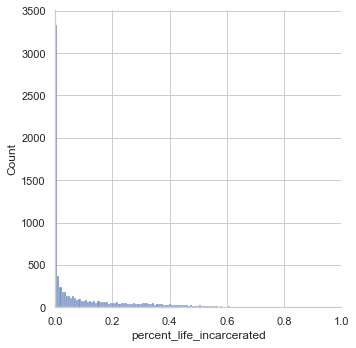

DescribeResult(nobs=7836, minmax=(0.0, 0.7374064837905236), mean=0.10513333388569879, variance=0.022729831832327574, skewness=1.5254844381598762, kurtosis=1.4239760530046581)


In [25]:
sns.displot(df['percent_life_incarcerated'], bins=100)
plt.xlim(0,1)
plt.show()
print(stats.describe(df['percent_life_incarcerated']))

Again, highly right-skewed, as would be expected.

Let's take another look at 'days_from_custody_to_death', but this time let's "bin up" the values to get a general idea of how long most people manage to survive.

In [26]:
days_categ = pd.cut(df['days_from_custody_to_death'], [-1,1,30,730,3650,7300,float('inf')], labels=['1 day','2 days to 1 month','1 month to 2 years','2 years to 10 years','10 years to 20 years','More than 20 years'])
print(days_categ.value_counts().sort_index())

1 day                   2050
2 days to 1 month        713
1 month to 2 years      1613
2 years to 10 years     1635
10 years to 20 years    1038
More than 20 years       787
Name: days_from_custody_to_death, dtype: int64


More evidence of a possible "sink or swim" phenomenon, but we can't be sure.  

Remember from above that our goal is to predict 'manner_of_death', which has six classes.  The value counts for each class are listed below.

In [27]:
df['manner_of_death'].value_counts()

NATURAL CAUSES/ILLNESS       4635
SUICIDE                      1124
HOMICIDE                     1065
OTHER, SPECIFY                415
ALCOHOL/DRUG INTOXICATION     312
ACCIDENTAL                    285
Name: manner_of_death, dtype: int64

Obviously, natural causes/illness dominates, as one expects it would, but there are still way more homicides, accidents, and suicides than one would expect in the general population.  

Next, we're going to show a bar graph of each of our chosen columns, for clarity.  The data in most categories is very lopsided.

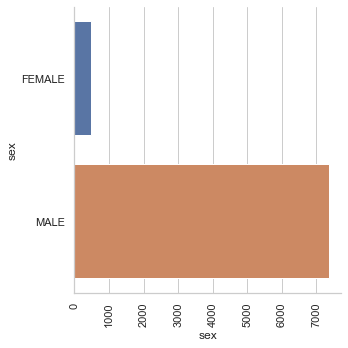

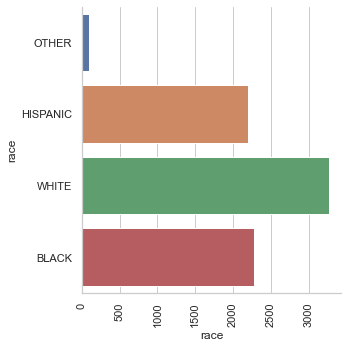

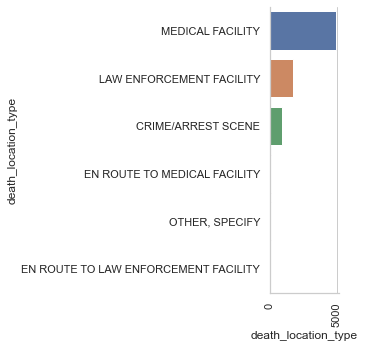

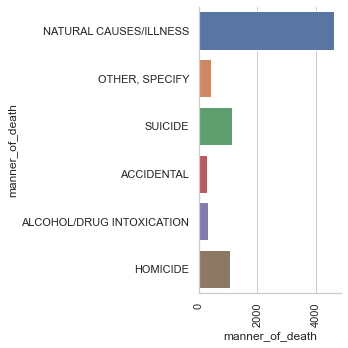

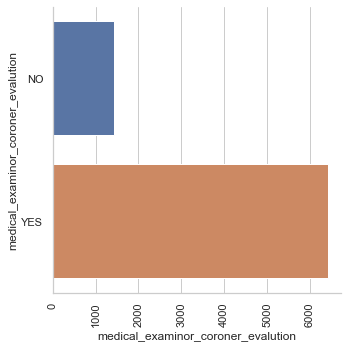

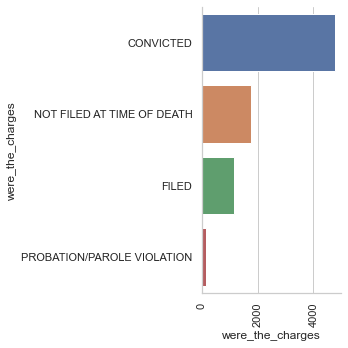

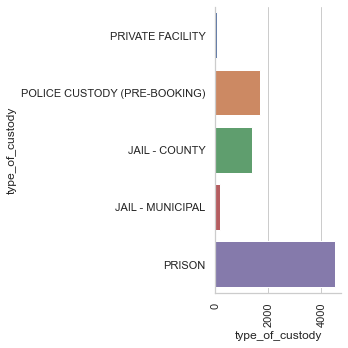

C:\Users\jason\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
<ipython-input-28-c4289db618f6>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


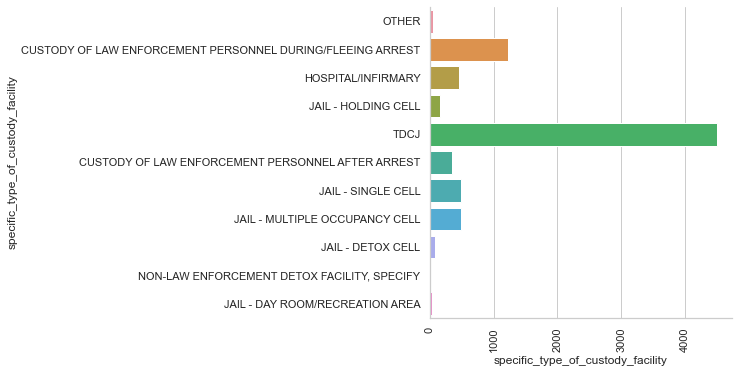

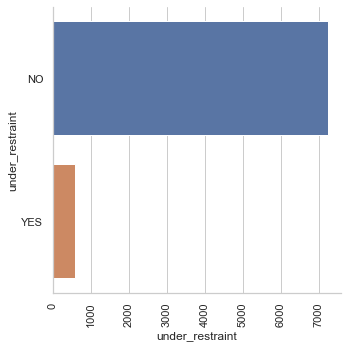

In [28]:
non_numeric_columns = df.select_dtypes(['object']).columns


for i, column in enumerate(non_numeric_columns):
    sns.catplot(y=column, kind='count', data=df)
    plt.xlabel(column)
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.show()

Below, we see that there are some subcategories of our columns above that are just too tiny to be useful as features by themselves.

In [29]:
print(df['specific_type_of_custody_facility'].value_counts())
print('-'*45)
print(df['death_location_type'].value_counts())

TDCJ                                                          4505
CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST    1231
JAIL - SINGLE CELL                                             492
JAIL - MULTIPLE OCCUPANCY CELL                                 492
HOSPITAL/INFIRMARY                                             451
CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST              343
JAIL - HOLDING CELL                                            153
JAIL - DETOX CELL                                               79
OTHER                                                           54
JAIL - DAY ROOM/RECREATION AREA                                 35
NON-LAW ENFORCEMENT DETOX FACILITY, SPECIFY                      1
Name: specific_type_of_custody_facility, dtype: int64
---------------------------------------------
MEDICAL FACILITY                        4938
LAW ENFORCEMENT FACILITY                1715
CRIME/ARREST SCENE                       942
OTHER, SPECIFY              

Our final analysis is going to (attempt) to use subcategories of the above as their own features.  ''NON-LAW ENFORCEMENT DETOX FACILITY, SPECIFY' and 'EN ROUTE TO LAW ENFORCEMENT FACILITY' are simply too small to be useful, and might mess up the count.

In [30]:
df = df[(df['specific_type_of_custody_facility'] != 'NON-LAW ENFORCEMENT DETOX FACILITY, SPECIFY') & 
        (df['death_location_type'] != 'EN ROUTE TO LAW ENFORCEMENT FACILITY')]

**<font size="10">Feature Elimination</font>**

At this point, we have kept 10 columns from our original 53, and created one new column.  However, most columns contain several subcategories that will be useful for prediction, and will eventually inhabit their own column. 

In total, we can derive 37 features from our chosen columns.  However, some of those features will be redundant with one another, and therefore discarded so as to not sully the analysis.  Others can be determined to be unimportant through the use of Recursive Feature Elimination with Cross Validation, employing a Random Forest.

Below, we will first break up the columns into separate features, scale the data, run a multicollinearity test, eliminate redundant features, then run an RFECV to find other unimportant features.

Note: we are going to perform our multicollinearity check and our RFECV only on the training dataset that we will use later for model evaluation, to avoid data leakage.

The code below will break up the features and scale the data.

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df_features = df.drop(['manner_of_death'], axis=1)

X = df_features
y = df.manner_of_death

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57, shuffle=True, stratify=y)



cat_cols = ['sex', 
            'race', 
            'death_location_type', 
            'medical_examinor_coroner_evalution', 
            'were_the_charges', 
            'type_of_custody', 
            'specific_type_of_custody_facility',
            'under_restraint']
drop_cats = ['FEMALE', 
             'OTHER',
             'OTHER, SPECIFY',
             'NO',
             'PROBATION/PAROLE VIOLATION',
             'PRIVATE FACILITY',
             'OTHER',
             'YES']

num_cols = ['age_at_time_of_death', 
            'days_from_custody_to_death',
            'percent_life_incarcerated']

preprocessing = ColumnTransformer(
    [
        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale_nums", MinMaxScaler(), num_cols),
    ], remainder = 'passthrough'
)

X_train_exp = X_train.copy()

preprocessing.fit(X_train_exp)
X_train_trans = preprocessing.transform(X_train_exp)
X_train_exp = pd.DataFrame(X_train_trans, index=X_train_exp.index)

cat_names = preprocessing.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)

new_col_names = cat_names + num_cols

X_train_exp.columns = new_col_names
X_train_exp

sex_MALE  race_BLACK  race_HISPANIC  race_WHITE  \
6634       1.0         1.0            0.0         0.0   
8421       0.0         1.0            0.0         0.0   
5620       1.0         1.0            0.0         0.0   
4941       1.0         0.0            1.0         0.0   
6297       1.0         0.0            1.0         0.0   
...        ...         ...            ...         ...   
7754       1.0         0.0            0.0         1.0   
5931       1.0         0.0            0.0         1.0   
8919       1.0         1.0            0.0         0.0   
4509       1.0         1.0            0.0         0.0   
6511       1.0         1.0            0.0         0.0   

      death_location_type_CRIME/ARREST SCENE  \
6634                                     0.0   
8421                                     0.0   
5620                                     0.0   
4941                                     0.0   
6297                                     0.0   
...                                      ...   
7754                                     1.0   
5931                                     0.0   
8919                                     0.0   
4509                                     0.0   
6511                                     0.0   

      death_location_type_EN ROUTE TO MEDICAL FACILITY  \
6634                                               0.0   
8421                                               0.0   
5620                                               0.0   
4941                                               0.0   
6297                                               1.0   
...                                                ...   
7754                                               0.0   
5931                                               0.0   
8919                                               0.0   
4509                                               0.0   
6511                                               0.0   

      death_location_type_LAW ENFORCEMENT FACILITY  \
6634                                           1.0   
8421                                           1.0   
5620                                           0.0   
4941                                           0.0   
6297                                           0.0   
...                                            ...   
7754                                           0.0   
5931                                           0.0   
8919                                           0.0   
4509                                           0.0   
6511                                           0.0   

      death_location_type_MEDICAL FACILITY  \
6634                                   0.0   
8421                                   0.0   
5620                                   1.0   
4941                                   1.0   
6297                                   0.0   
...                                    ...   
7754                                   0.0   
5931                                   1.0   
8919                                   1.0   
4509                                   1.0   
6511                                   1.0   

      medical_examinor_coroner_evalution_YES  were_the_charges_CONVICTED  \
6634                                     1.0                         0.0   
8421                                     1.0                         0.0   
5620                                     1.0                         0.0   
4941                                     1.0                         1.0   
6297                                     1.0                         0.0   
...                                      ...                         ...   
7754                                     1.0                         0.0   
5931                                     1.0                         1.0   
8919                                     1.0                         1.0   
4509                                     1.0                         1.0   
6511     

This code will tell us which features are highly correlated, and therefore candidates for redundant variables:

In [32]:
X_feat_corr = X_train_exp

correlated_features = set()
correlation_matrix = X_feat_corr.corr(method='pearson')

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = X_feat_corr.columns[i]
            colname2 = X_feat_corr.columns[j]
           
            correlated_features.add(i)
            print(f"{colname}, {colname2}:{correlation_matrix.iloc[i, j]}")

type_of_custody_POLICE CUSTODY (PRE-BOOKING), were_the_charges_NOT FILED AT TIME OF DEATH:0.8314983383298017
type_of_custody_PRISON, were_the_charges_CONVICTED:0.9309909809941577
specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST, type_of_custody_POLICE CUSTODY (PRE-BOOKING):0.8261519334373219
specific_type_of_custody_facility_TDCJ, were_the_charges_CONVICTED:0.9283482523135385
specific_type_of_custody_facility_TDCJ, type_of_custody_PRISON:0.9911849063445702
percent_life_incarcerated, days_from_custody_to_death:0.9701365653671872


We are going to drop the columns below.  They are redundant.

In [33]:
multi_col_drop = ['type_of_custody_POLICE CUSTODY (PRE-BOOKING)',
                                'specific_type_of_custody_facility_TDCJ',
                                'percent_life_incarcerated',
                                'were_the_charges_CONVICTED']

X_train_red = X_train_exp.drop(multi_col_drop, axis=1)

We have eliminated our initial list of highly redundant features (and looking at the correlations, it's easy to see why that's the case).  Let's also take a look at a heatmap of the features at this point, to be sure we didn't miss anything.  Between-feature correlations of greater than .6 will be outlined in red on the heatmap.  Also, all such pairs will be listed below the figure.

In [34]:
X_train_red_corr = X_train_red.corr(method='pearson')

correlated_features = set()
correlated_tuples_flip = []
correlated_tuples_info= []
correlation_matrix = X_train_red_corr

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.6:
            colname = X_train_red_corr.columns[i]
            colname2 = X_train_red_corr.columns[j]
           
            correlated_features.add(i)
            correlated_tuples_flip.append((X_train_red.columns.get_loc(colname2), X_train_red.columns.get_loc(colname)))
            correlated_tuples_info.append((colname, colname2, correlation_matrix.iloc[i, j]))                        

In [35]:
from matplotlib.patches import Rectangle

cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
mask = np.triu(np.ones_like(X_train_red_corr, dtype=np.bool))

sns.set_context("paper", font_scale=10)
cmap.set_bad('w')
fig, ax = plt.subplots(figsize=(128, 128))
heatmap = sns.heatmap(X_train_red_corr, mask=mask, ax=ax, cmap=cmap)

for i in correlated_tuples_flip:
    heatmap.add_patch(Rectangle(i, 1, 1, fill=False, edgecolor='red', lw=20))
plt.show()

for x in correlated_tuples_info: 
    print(x[2])
    print(x[0])
    print(x[1])
    print('-'*120)


-0.695175389721797
death_location_type_MEDICAL FACILITY
death_location_type_LAW ENFORCEMENT FACILITY
------------------------------------------------------------------------------------------------------------------------
0.6549518920705905
type_of_custody_JAIL - COUNTY
were_the_charges_FILED
------------------------------------------------------------------------------------------------------------------------
-0.6271909128592253
type_of_custody_PRISON
were_the_charges_NOT FILED AT TIME OF DEATH
------------------------------------------------------------------------------------------------------------------------
0.6632268139599081
specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST
death_location_type_CRIME/ARREST SCENE
------------------------------------------------------------------------------------------------------------------------
0.7139175212809548
specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING 

Nothing out of the ordinary in the above.

Next, let's run the RFECV on our data now that we've eliminated redundancies.

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train_red, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=101), n_jobs=-1,
      scoring='accuracy')

In [37]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 21


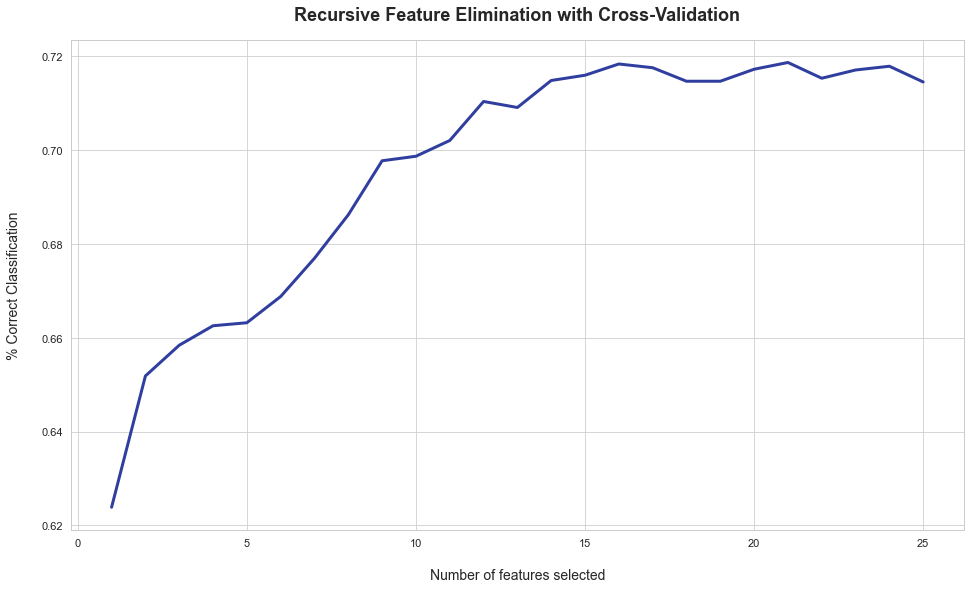

In [38]:
sns.set_context("paper", font_scale=1.25)
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [39]:
rfecv_drop = list(X_train_red.columns[np.where(rfecv.support_ == False)[0]])
print(rfecv_drop)

X_train_red.drop(X_train_red.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_train_fin = X_train_red

['death_location_type_EN ROUTE TO MEDICAL FACILITY', 'specific_type_of_custody_facility_JAIL - DAY ROOM/RECREATION AREA', 'specific_type_of_custody_facility_JAIL - DETOX CELL', 'specific_type_of_custody_facility_JAIL - HOLDING CELL']


In [ ]:
dset = pd.DataFrame()
dset['attr'] = X_train_fin.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(8, 15))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=28, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=28, labelpad=20)
plt.show()

Clearly, due to the preponderance of natural causes/illness deaths in the dataset, we should expect to see 'age_at_time_of_death' and 'days_from_custody_to_death' high on the list of feature importances.  Others are more suprising.  

Let's again take a look at the heatmp of features, now that we're done with this stage.  I have again highlighted in red all correlations between features with an absolute value greater than .6.  The names and values for each of these tuples are again printed below the heatmap.

In [41]:
X_train_fin_corr = X_train_fin.corr(method='pearson')

correlated_features = set()
correlated_tuples_flip = []
correlated_tuples_info= []
correlation_matrix = X_train_fin_corr

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.6:
            colname = X_train_fin_corr.columns[i]
            colname2 = X_train_fin_corr.columns[j]
           
            correlated_features.add(i)
            correlated_tuples_flip.append((X_train_fin.columns.get_loc(colname2), X_train_fin.columns.get_loc(colname)))
            correlated_tuples_info.append((colname, colname2, correlation_matrix.iloc[i, j]))      

In [42]:
mask = np.triu(np.ones_like(X_train_fin_corr, dtype=np.bool))
sns.set_context("paper", font_scale=10)
cmap.set_bad('w')
fig, ax = plt.subplots(figsize=(128, 128))
heatmap = sns.heatmap(X_train_fin_corr, mask=mask, ax=ax, cmap=cmap)

for i in correlated_tuples_flip:
    heatmap.add_patch(Rectangle(i, 1, 1, fill=False, edgecolor='red', lw=20))
plt.show()

for x in correlated_tuples_info: 
    print(x[2])
    print(x[0])
    print(x[1])
    print('-'*120)

-0.695175389721797
death_location_type_MEDICAL FACILITY
death_location_type_LAW ENFORCEMENT FACILITY
------------------------------------------------------------------------------------------------------------------------
0.6549518920705905
type_of_custody_JAIL - COUNTY
were_the_charges_FILED
------------------------------------------------------------------------------------------------------------------------
-0.6271909128592253
type_of_custody_PRISON
were_the_charges_NOT FILED AT TIME OF DEATH
------------------------------------------------------------------------------------------------------------------------
0.6632268139599081
specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST
death_location_type_CRIME/ARREST SCENE
------------------------------------------------------------------------------------------------------------------------
0.7139175212809548
specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING 

Nothing out of the ordinary here, even after eliminating features that the RFECV discarded.

**<font size="10">Modeling</font>**

At long last, we've narrowed down our original 37 features into a more manageable 22 and are ready to begin modeling.

We're going to approach 'manner_of_death' prediction in three ways: 

1. Use SVC, Random Forest, and Logisitic Regression to predict 'manner_of_death' as a multiclass classification problem.

2. Use SVC, Random Forest, and Logistic Regression to predict 'manner_of_death' as a binary classification problem between 'NATURAL CAUSES/ILLNESS' and 'NON NATURAL'.

3. Use SVC, Random Forest, and Logistic Regression to predict 'manner_of_death' as a bineary classification problem between 'HOMICIDE' and 'NON HOMICIDE' deaths.

In each case, we are going to be vary hyperparameters with GridSearchCV for each of SVC, Random Forest, and Logistic Regression until we find the best model for the task of each type.  Then we'll make a choice as to which will be use for interpretation.  Overall, given two modeling techniques with near similar test results, we're going to favor those with higher interpretability and/or higher recall.  Our driving imperative is to avoid false negatives --  or Type II errors.  As a moral issue, with the comparisons above, and across all causes, it is better to employ a model that sometimes classifies (for example) a non-homicide as a homicide (false positive) than one that sometimes classifies a homicide as a non-homicide (false negative).  By favoring higher recall, we are saying that we prefer to correctly classify all the homicides, even at the cost of more false positives.

In [43]:
##Run pipeplines: Logistic Regression, SVM, Decision Tree, and Random Forest.

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report

In [44]:
cat_cols = ['sex', 
            'race', 
            'death_location_type', 
            'medical_examinor_coroner_evalution', 
            'were_the_charges', 
            'type_of_custody', 
            'specific_type_of_custody_facility',
            'under_restraint']
drop_cats = ['FEMALE', 
             'OTHER',
             'OTHER, SPECIFY',
             'NO',
             'PROBATION/PAROLE VIOLATION',
             'PRIVATE FACILITY',
             'OTHER',
             'YES']

num_cols = ['age_at_time_of_death', 
            'days_from_custody_to_death',
            'percent_life_incarcerated']

total_drop = multi_col_drop + rfecv_drop
unwanted = [X_train_exp.columns.get_loc(c) for c in total_drop if c in X_train_exp]

preprocessing_1 = ColumnTransformer(
    [
        ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale_nums", MinMaxScaler(), num_cols),
    ], remainder = 'passthrough'
)

preprocessing_2 = ColumnTransformer(
    [
        ("drop_unwanted", 'drop', unwanted),
    ], remainder = 'passthrough'
)

**<font size="5">Multiclassifier: All Manners of Death</font>**

In [45]:
##Create an SVC pipeline

pipeline_svc = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ("svc", SVC())
])

grid_svc = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2,3],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

pipeline_cv_svc = GridSearchCV(pipeline_svc, grid_svc, cv=2, n_jobs=-1)

In [46]:
pipeline_cv_svc.fit(X_train, y_train)

print("Best params:")
print(pipeline_cv_svc.best_params_)

print(f"\ntrain score: {pipeline_cv_svc.score(X_train, y_train):.3f}")
print(f"test score: {pipeline_cv_svc.score(X_test, y_test):.3f}\n")

y_pred = pipeline_cv_svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'svc__C': 100, 'svc__degree': 2, 'svc__kernel': 'linear'}

train score: 0.757
test score: 0.750

[[  0  10  19  22   1   5]
 [  0  36  11   6   1   8]
 [  1  12 175  18   1   6]
 [  0   5   2 874   0  46]
 [  0   7  17  51   1   7]
 [  1   5  46  83   1  89]]
                           precision    recall  f1-score   support

               ACCIDENTAL       0.00      0.00      0.00        57
ALCOHOL/DRUG INTOXICATION       0.48      0.58      0.53        62
                 HOMICIDE       0.65      0.82      0.72       213
   NATURAL CAUSES/ILLNESS       0.83      0.94      0.88       927
           OTHER, SPECIFY       0.20      0.01      0.02        83
                  SUICIDE       0.55      0.40      0.46       225

                 accuracy                           0.75      1567
                macro avg       0.45      0.46      0.44      1567
             weighted avg       0.69      0.75      0.71      1567



In [47]:
##Create a Random Forest Pipeline

pipeline_rdf = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ("rdf", RandomForestClassifier(random_state=57, n_jobs=-1))
])

grid_rdf = {
    "rdf__n_estimators": [75,125,150,175],
    "rdf__min_samples_split": [18,20,22,24,26],
    "rdf__max_features": ['auto', 'sqrt', 'log2'],
    "rdf__max_depth": [10,11,12,13,14,15,16,17],

}

pipeline_cv_rdf = GridSearchCV(pipeline_rdf, grid_rdf, cv=2, n_jobs=-1)

In [48]:
pipeline_cv_rdf.fit(X_train, y_train)

print("Best params:")
print(pipeline_cv_rdf.best_params_)

print(f"Train score: {pipeline_cv_rdf.score(X_train, y_train):.4f}")
print(f"Test score: {pipeline_cv_rdf.score(X_test,y_test):.4f}")

y_pred = pipeline_cv_rdf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'rdf__max_depth': 13, 'rdf__max_features': 'auto', 'rdf__min_samples_split': 24, 'rdf__n_estimators': 75}
Train score: 0.7894
Test score: 0.7479
[[  0   9  20  23   1   4]
 [  0  40  10   5   0   7]
 [  0   9 170  17   1  16]
 [  0   5   1 862   0  59]
 [  0   6  18  50   1   8]
 [  0   4  40  82   0  99]]
                           precision    recall  f1-score   support

               ACCIDENTAL       0.00      0.00      0.00        57
ALCOHOL/DRUG INTOXICATION       0.55      0.65      0.59        62
                 HOMICIDE       0.66      0.80      0.72       213
   NATURAL CAUSES/ILLNESS       0.83      0.93      0.88       927
           OTHER, SPECIFY       0.33      0.01      0.02        83
                  SUICIDE       0.51      0.44      0.47       225

                 accuracy                           0.75      1567
                macro avg       0.48      0.47      0.45      1567
             weighted avg       0.69      0.75      0.71      1567



C:\Users\jason\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
importances = pipeline_cv_rdf.best_estimator_["rdf"].feature_importances_
im_df = pd.DataFrame({"feat": X_train_fin.columns, "feature_importances": importances})
im_df.sort_values("feature_importances", ascending=False)

feat  \
19                                                                          age_at_time_of_death   
20                                                                    days_from_custody_to_death   
9                                                    were_the_charges_NOT FILED AT TIME OF DEATH   
14  specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST   
12                                                                        type_of_custody_PRISON   
4                                                         death_location_type_CRIME/ARREST SCENE   
18                                                                            under_restraint_NO   
7                                                         medical_examinor_coroner_evalution_YES   
6                                                           death_location_type_MEDICAL FACILITY   
10                                                                 type_of_custody_JAIL - COUNTY   
17                                          specific_type_of_custody_facility_JAIL - SINGLE CELL   
1                                                                                     race_BLACK   
5                                                   death_location_type_LAW ENFORCEMENT FACILITY   
8                                                                         were_the_charges_FILED   
13           specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST   
3                                                                                     race_WHITE   
11                                                              type_of_custody_JAIL - MUNICIPAL   
16                              specific_type_of_custody_facility_JAIL - MULTIPLE OCCUPANCY CELL   
0                                                                                       sex_MALE   
2                                                                                  race_HISPANIC   
15                                          specific_type_of_custody_facility_HOSPITAL/INFIRMARY   

    feature_importances  
19             0.225881  
20             0.183345  
9              0.131221  
14             0.098024  
12             0.069403  
4              0.052297  
18             0.043898  
7              0.037403  
6              0.026003  
10             0.020183  
17             0.015448  
1              0.014164  
5              0.013841  
8              0.012877  
13             0.011477  
3              0.010485  
11             0.007592  
16             0.006812  
0              0.006799  
2              0.006731  
15             0.006116

In [50]:
##Create a Logistic Regression Pipeline

pipeline_log = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ("log", LogisticRegression(max_iter=10000, n_jobs=-1))
])

grid_log = {
    "log__penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "log__C": np.logspace(-4, 4),
    "log__solver": ['lbfgs', 'saga', 'sag', 'newton-cg', 'liblinear'],
}

pipeline_cv_log = GridSearchCV(pipeline_log, grid_log, cv=2, n_jobs=-1)

In [51]:
pipeline_cv_log.fit(X_train, y_train)

print("Best params:")
print(pipeline_cv_log.best_params_)

print(f"Train score: {pipeline_cv_log.score(X_train, y_train):.4f}")
print(f"Test score: {pipeline_cv_log.score(X_test,y_test):.4f}")

y_pred = pipeline_cv_log.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best params:
{'log__C': 35.564803062231285, 'log__penalty': 'l1', 'log__solver': 'saga'}
Train score: 0.7561
Test score: 0.7505
[[  0   9  20  23   0   5]
 [  0  32  15   5   3   7]
 [  0   8 179  20   0   6]
 [  0   4   2 876   1  44]
 [  0   9  20  48   0   6]
 [  1   2  46  87   0  89]]
                           precision    recall  f1-score   support

               ACCIDENTAL       0.00      0.00      0.00        57
ALCOHOL/DRUG INTOXICATION       0.50      0.52      0.51        62
                 HOMICIDE       0.63      0.84      0.72       213
   NATURAL CAUSES/ILLNESS       0.83      0.94      0.88       927
           OTHER, SPECIFY       0.00      0.00      0.00        83
                  SUICIDE       0.57      0.40      0.47       225

                 accuracy                           0.75      1567
                macro avg       0.42      0.45      0.43      1567
             weighted avg       0.68      0.75      0.71      1567



Let's create a dataframe that shows the logistic regression coefficients for each class converted into log odds.

In [52]:
log_coef_mul = np.exp(pipeline_cv_log.best_estimator_["log"].coef_)
log_coef_mul = pd.DataFrame(log_coef_mul).transpose()
log_coef_mul.columns = list(pipeline_cv_log.best_estimator_["log"].classes_)
log_coef_mul['features'] = X_train_fin.columns 
log_coef_mul

ACCIDENTAL  ALCOHOL/DRUG INTOXICATION   HOMICIDE  NATURAL CAUSES/ILLNESS  \
0     1.007930                   0.706771   1.320162                0.730989   
1     0.997705                   1.161037   0.999793                1.157766   
2     1.150497                   0.959103   1.165933                0.809487   
3     1.147675                   1.094451   1.078915                0.630781   
4     0.980485                   0.354277   2.881168                0.348522   
5     0.590714                   0.810687   2.031055                1.254088   
6     0.737289                   1.058309   2.129083                1.502967   
7     1.021573                   0.999926   3.395236                0.082281   
8     1.042370                   0.962696   1.440203                0.402284   
9     1.667518                   1.376654   1.995553                0.216123   
10    1.297492                   0.999994   0.294806                2.208199   
11    1.497092                   3.332769   0.172306                1.150478   
12    1.134319                   0.210860   0.950778                3.386102   
13    0.521353                   0.770983   5.503408                1.048029   
14    1.353226                   0.666135  12.545166                0.409807   
15    0.912426                   0.539787   2.213703                1.517739   
16    0.876768                   0.417210   1.248004                1.913465   
17    0.563400                   0.470807   0.654098                1.472183   
18    0.607096                   0.186551   3.499677                1.422717   
19    1.000000                   0.181604   0.837598              282.156439   
20    3.481010                   0.048128   4.555777                0.761032   

    OTHER, SPECIFY   SUICIDE  \
0         0.999238  1.260649   
1         1.159678  0.461192   
2         1.214292  0.600563   
3         0.999595  0.944772   
4         1.303243  2.153897   
5         0.511796  1.581681   
6         0.561986  0.714040   
7         0.565569  1.468861   
8         1.129895  0.999973   
9         0.999920  0.587770   
10        1.216884  0.392426   
11        0.996983  0.442529   
12        1.432475  0.861151   
13        1.040964  0.429481   
14        1.000019  0.713212   
15        1.374735  0.435975   
16        0.931986  1.254586   
17        1.630757  2.430035   
18        0.509867  3.469640   
19        3.330787  0.132934   
20        2.778460  0.625880   

                                                                                        features  
0                                                                                       sex_MALE  
1                                                                                     race_BLACK  
2                                                                                  race_HISPANIC  
3                                                                                     race_WHITE  
4                                                         death_location_type_CRIME/ARREST SCENE  
5                                                   death_location_type_LAW ENFORCEMENT FACILITY  
6                                                           death_location_type_MEDICAL FACILITY  
7                                                         medical_examinor_coroner_evalution_YES  
8                                                                         were_the_charges_FILED  
9                                                    were_the_charges_NOT FILED AT TIME OF DEATH  
10                                                                 type_of_custody_JAIL - COUNTY  
11                                                              type_of_custody_JAIL - MUNICIPAL  
12                                                                        type_of_custody_PRISON  
13           specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST  
14  specific_type_of_custody_facility_CUSTODY OF LAW 

In terms of recall, all models did best at predicting 'NATURAL CAUSES/ILLNESS', 'HOMICIDE', 'ALCOHOL/DRUG INTOXICATION', and 'SUICIDE' -- in that order. 

For all 3 pipelines above, the models totally failed to correctly predict both the 'ACCIDENTAL' and 'OTHER, SPECIFY' classes.  This is a good sign, for it provides some evidence that those categories were not tampered with (i.e. for example, a prison, to avoid liability, might have an incentive to misclassify homicide deaths as "accidental" to avoid scrutiny).

Interestingly, 'HOMICIDE' deaths were most often misclassified as 'SUICIDE' deaths.  By a plurality, 'NATURAL CAUSES/ILLNESS' deaths were also most often misclassified as 'SUICIDE' deaths.  The majority of 'SUICIDE' misclassifications were as 'NATURAL CAUSES/ILLNESS'.  'ALCOHOL/DRUG INTOXICATION' misclassifications were all over the place.

On the overall test data, Random Forest performed the best out of all three, but for reasons of interpretability, and because we value recall above all else (and the weighted averages of recall for all 3 pipelines were about the same), I'm going to choose logistic regression as my favored model for the multiclass problem.

Even a quick look at the above dataframe shows a few key facts.  Obviously, the process of getting arrested is quite dangerous in terms of homicide odds.  Getting older dominates all other factors in determining natural causes deaths, but being in prison or being in a county jail appreciably raise your odds of dying by natural causes.  Being in a single cell or holding cell environment vastly increases the odds of suicide.  People taken into custody at municipal jails have much higher odds of dying from alchohol or drug intoxication.  All of this accords with experience.

**<font size="5">Binary Classifier: Natural Causes/Illness vs. Non-Natural</font>**

For the sake of the machine learning algorithms' correct operation, we're going to label our target class (non-natural, i.e. the deaths with less typical circumstances, and therefore with more to learn from) as "1" and everything else ('NATURAL CAUSES/ILLNESS deaths) as "0".  Remember from above that 'NATURAL CAUSES/ILLNESS' deaths absolutely dwarfed every other 'manner_of_death' in the dataset.  Therefore, to get better results from our models, we're going to use SMOTE to upsample the minority class (in this case, our target class, all the non-natural deaths).  This will prevent us from getting good results just by chance.

In [53]:
y_train_nat = np.where(y_train == 'NATURAL CAUSES/ILLNESS', 0, 1)
y_test_nat = np.where(y_test == 'NATURAL CAUSES/ILLNESS', 0, 1)

In [54]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

##Create an SVC pipeline

pipeline_svc = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ('sampling', SMOTE(n_jobs=-1)),
    ("svc", SVC())
])

grid_svc = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2,3],
    "svc__C": [1.0, 10, 100, 1000],
}

pipeline_cv_svc = GridSearchCV(pipeline_svc, grid_svc, cv=2, n_jobs=-1)

In [55]:
pipeline_cv_svc.fit(X_train, y_train_nat)

print("Best params:")
print(pipeline_cv_svc.best_params_)

print(f"\ntrain score: {pipeline_cv_svc.score(X_train, y_train_nat):.3f}")
print(f"test score: {pipeline_cv_svc.score(X_test, y_test_nat):.3f}\n")

y_pred = pipeline_cv_svc.predict(X_test)
print(confusion_matrix(y_test_nat, y_pred))
print(classification_report(y_test_nat, y_pred))

Best params:
{'svc__C': 100, 'svc__degree': 3, 'svc__kernel': 'linear'}

train score: 0.872
test score: 0.851

[[806 121]
 [113 527]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       927
           1       0.81      0.82      0.82       640

    accuracy                           0.85      1567
   macro avg       0.85      0.85      0.85      1567
weighted avg       0.85      0.85      0.85      1567



Try to extract probability.

In [56]:
## Because a linear kernel was chosen above...

coef = pipeline_cv_svc.best_estimator_["svc"].coef_[0]
im_df = pd.DataFrame({"feat": X_train_fin.columns, "coef_sq": coef**2})
im_df.sort_values("coef_sq", ascending=False)

feat  \
19                                                                          age_at_time_of_death   
9                                                    were_the_charges_NOT FILED AT TIME OF DEATH   
7                                                         medical_examinor_coroner_evalution_YES   
12                                                                        type_of_custody_PRISON   
10                                                                 type_of_custody_JAIL - COUNTY   
8                                                                         were_the_charges_FILED   
3                                                                                     race_WHITE   
16                              specific_type_of_custody_facility_JAIL - MULTIPLE OCCUPANCY CELL   
4                                                         death_location_type_CRIME/ARREST SCENE   
20                                                                    days_from_custody_to_death   
15                                          specific_type_of_custody_facility_HOSPITAL/INFIRMARY   
6                                                           death_location_type_MEDICAL FACILITY   
14  specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST   
2                                                                                  race_HISPANIC   
18                                                                            under_restraint_NO   
0                                                                                       sex_MALE   
13           specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST   
11                                                              type_of_custody_JAIL - MUNICIPAL   
17                                          specific_type_of_custody_facility_JAIL - SINGLE CELL   
5                                                   death_location_type_LAW ENFORCEMENT FACILITY   
1                                                                                     race_BLACK   

      coef_sq  
19  27.597706  
9    2.205060  
7    1.686777  
12   1.008981  
10   0.892616  
8    0.839178  
3    0.572081  
16   0.442628  
4    0.418934  
20   0.334086  
15   0.320034  
6    0.266049  
14   0.251884  
2    0.130842  
18   0.124574  
0    0.113169  
13   0.088999  
11   0.041095  
17   0.001992  
5    0.001047  
1    0.000777

In [57]:
##Create a Random Forest Pipeline

pipeline_rdf = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ('sampling', SMOTE(n_jobs=-1)),
    ("rdf", RandomForestClassifier(random_state=57, n_jobs=-1))
])

grid_rdf = {
    "rdf__n_estimators": [75,125,150,175],
    "rdf__min_samples_split": [18,20,22,24,26],
    "rdf__max_features": ['auto', 'sqrt', 'log2'],
    "rdf__max_depth": [10,11,12,13,14,15,16,17],

}

pipeline_cv_rdf = GridSearchCV(pipeline_rdf, grid_rdf, cv=2, n_jobs=-1)

In [58]:
pipeline_cv_rdf.fit(X_train, y_train_nat)

print("Best params:")
print(pipeline_cv_rdf.best_params_)

print(f"Train score: {pipeline_cv_rdf.score(X_train, y_train_nat):.4f}")
print(f"Test score: {pipeline_cv_rdf.score(X_test,y_test_nat):.4f}")

y_pred = pipeline_cv_rdf.predict(X_test)
print(confusion_matrix(y_test_nat, y_pred))
print(classification_report(y_test_nat, y_pred))

Best params:
{'rdf__max_depth': 10, 'rdf__max_features': 'auto', 'rdf__min_samples_split': 22, 'rdf__n_estimators': 175}
Train score: 0.8889
Test score: 0.8551
[[804 123]
 [104 536]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       927
           1       0.81      0.84      0.83       640

    accuracy                           0.86      1567
   macro avg       0.85      0.85      0.85      1567
weighted avg       0.86      0.86      0.86      1567



In [59]:
importances = pipeline_cv_rdf.best_estimator_["rdf"].feature_importances_
im_df = pd.DataFrame({"feat": X_train_fin.columns, "feature_importances": importances})
im_df.sort_values("feature_importances", ascending=False)

feat  \
19                                                                          age_at_time_of_death   
20                                                                    days_from_custody_to_death   
12                                                                        type_of_custody_PRISON   
9                                                    were_the_charges_NOT FILED AT TIME OF DEATH   
7                                                         medical_examinor_coroner_evalution_YES   
14  specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST   
4                                                         death_location_type_CRIME/ARREST SCENE   
6                                                           death_location_type_MEDICAL FACILITY   
10                                                                 type_of_custody_JAIL - COUNTY   
8                                                                         were_the_charges_FILED   
18                                                                            under_restraint_NO   
1                                                                                     race_BLACK   
17                                          specific_type_of_custody_facility_JAIL - SINGLE CELL   
16                              specific_type_of_custody_facility_JAIL - MULTIPLE OCCUPANCY CELL   
5                                                   death_location_type_LAW ENFORCEMENT FACILITY   
3                                                                                     race_WHITE   
13           specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST   
15                                          specific_type_of_custody_facility_HOSPITAL/INFIRMARY   
2                                                                                  race_HISPANIC   
11                                                              type_of_custody_JAIL - MUNICIPAL   
0                                                                                       sex_MALE   

    feature_importances  
19             0.267534  
20             0.204840  
12             0.125326  
9              0.110974  
7              0.062591  
14             0.059340  
4              0.039941  
6              0.022860  
10             0.017290  
8              0.015239  
18             0.011915  
1              0.010600  
17             0.008205  
16             0.007972  
5              0.007452  
3              0.007128  
13             0.005873  
15             0.004925  
2              0.003435  
11             0.003303  
0              0.003255

In [60]:
##Create a Logistic Regression Pipeline

pipeline_log = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ('sampling', SMOTE(n_jobs=-1)),
    ("log", LogisticRegression(max_iter=10000, n_jobs=-1))
])

grid_log = {
    "log__penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "log__C": np.logspace(-4, 4),
    "log__solver": ['lbfgs', 'saga', 'sag', 'newton-cg', 'liblinear'],
}

pipeline_cv_log = GridSearchCV(pipeline_log, grid_log, cv=2, n_jobs=-1)

In [61]:
pipeline_cv_log.fit(X_train, y_train_nat)

print("Best params:")
print(pipeline_cv_log.best_params_)

print(f"Train score: {pipeline_cv_log.score(X_train, y_train_nat):.4f}")
print(f"Test score: {pipeline_cv_log.score(X_test,y_test_nat):.4f}")

y_pred = pipeline_cv_log.predict(X_test)
print(confusion_matrix(y_test_nat, y_pred))
print(classification_report(y_test_nat, y_pred))

C:\Users\jason\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best params:
{'log__C': 0.0009540954763499944, 'log__penalty': 'none', 'log__solver': 'newton-cg'}
Train score: 0.8691
Test score: 0.8475
[[804 123]
 [116 524]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       927
           1       0.81      0.82      0.81       640

    accuracy                           0.85      1567
   macro avg       0.84      0.84      0.84      1567
weighted avg       0.85      0.85      0.85      1567



In [62]:
coef = np.exp(pipeline_cv_log.best_estimator_["log"].coef_[0])
im_df = pd.DataFrame({"feat": X_train_fin.columns, "coef": coef})

im_df.reindex(im_df.coef.abs().sort_values(ascending=False).index)

feat  \
7                                                         medical_examinor_coroner_evalution_YES   
14  specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST   
9                                                    were_the_charges_NOT FILED AT TIME OF DEATH   
4                                                         death_location_type_CRIME/ARREST SCENE   
8                                                                         were_the_charges_FILED   
20                                                                    days_from_custody_to_death   
0                                                                                       sex_MALE   
3                                                                                     race_WHITE   
13           specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST   
5                                                   death_location_type_LAW ENFORCEMENT FACILITY   
17                                          specific_type_of_custody_facility_JAIL - SINGLE CELL   
2                                                                                  race_HISPANIC   
11                                                              type_of_custody_JAIL - MUNICIPAL   
15                                          specific_type_of_custody_facility_HOSPITAL/INFIRMARY   
6                                                           death_location_type_MEDICAL FACILITY   
1                                                                                     race_BLACK   
18                                                                            under_restraint_NO   
16                              specific_type_of_custody_facility_JAIL - MULTIPLE OCCUPANCY CELL   
12                                                                        type_of_custody_PRISON   
10                                                                 type_of_custody_JAIL - COUNTY   
19                                                                          age_at_time_of_death   

         coef  
7   16.674870  
14   5.616837  
9    5.423329  
4    4.842943  
8    3.149246  
20   2.079948  
0    1.613601  
3    1.400020  
13   1.114976  
5    1.112811  
17   0.967253  
2    0.928110  
11   0.725693  
15   0.596966  
6    0.570173  
1    0.569751  
18   0.559013  
16   0.480705  
12   0.300872  
10   0.291300  
19   0.001258

All three models did about the same in terms of test set accuracy and recall on both target and non-target classes (non-natural causes and NATURAL CAUSES/ILLNESS, respectively).  For reasons of interpretability, we choose Logisitic Regression.

From the above, we can see that a variety of features were associated with increased odds of a non-natural death, including being male, white, being in a holding cell, and dying at the scene.  Fleeing arrest seems especially dangerous.  I would guess that the higher death probabilities for white males, and in holding cells, reflect higher rates of suicide among whites, a trend seen in the general population.



**<font size="5">Binary Classifier: Homicide vs. Non-Homicide</font>**

For the below, our target class, labeled with "1" will be 'HOMICIDE' deaths. Because these are dwarfed by non-homicide deaths, we will again be using SMOTE to upsample our minority class and get more valid results.

In [63]:
y_train_hom = np.where(y_train == 'HOMICIDE', 1, 0)
y_test_hom = np.where(y_test == 'HOMICIDE', 1, 0)

In [64]:
##Create an SVC pipeline

pipeline_svc = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ('sampling', SMOTE(n_jobs=-1)),
    ("svc", SVC())
])

grid_svc = {
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__degree": [2,3],
    "svc__C": [1.0, 10, 100, 1000],
##    "svc__gamma": [.1,1,10,100],
}

pipeline_cv_svc = GridSearchCV(pipeline_svc, grid_svc, cv=2, n_jobs=-1)

In [65]:
pipeline_cv_svc.fit(X_train, y_train_hom)

print("Best params:")
print(pipeline_cv_svc.best_params_)

print(f"\ntrain score: {pipeline_cv_svc.score(X_train, y_train_hom):.3f}")
print(f"test score: {pipeline_cv_svc.score(X_test, y_test_hom):.3f}\n")

y_pred = pipeline_cv_svc.predict(X_test)
print(confusion_matrix(y_test_hom, y_pred))
print(classification_report(y_test_hom, y_pred))

Best params:
{'svc__C': 10, 'svc__degree': 2, 'svc__kernel': 'rbf'}

train score: 0.921
test score: 0.902

[[1237  117]
 [  36  177]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1354
           1       0.60      0.83      0.70       213

    accuracy                           0.90      1567
   macro avg       0.79      0.87      0.82      1567
weighted avg       0.92      0.90      0.91      1567



In [66]:
##Create a Random Forest Pipeline

pipeline_rdf = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ('sampling', SMOTE(n_jobs=-1)),
    ("rdf", RandomForestClassifier(random_state=57, n_jobs=-1))
])

grid_rdf = {
    "rdf__n_estimators": [75,125,150,175],
    "rdf__min_samples_split": [18,20,22,24,26],
    "rdf__max_features": ['auto', 'sqrt', 'log2'],
    "rdf__max_depth": [10,11,12,13,14,15,16,17],

}

pipeline_cv_rdf = GridSearchCV(pipeline_rdf, grid_rdf, cv=2, n_jobs=-1)

In [67]:
pipeline_cv_rdf.fit(X_train, y_train_hom)

print("Best params:")
print(pipeline_cv_rdf.best_params_)

print(f"Train score: {pipeline_cv_rdf.score(X_train, y_train_hom):.4f}")
print(f"Test score: {pipeline_cv_rdf.score(X_test,y_test_hom):.4f}")

y_pred = pipeline_cv_rdf.predict(X_test)
print(confusion_matrix(y_test_hom, y_pred))
print(classification_report(y_test_hom, y_pred))

Best params:
{'rdf__max_depth': 12, 'rdf__max_features': 'auto', 'rdf__min_samples_split': 20, 'rdf__n_estimators': 150}
Train score: 0.9266
Test score: 0.9068
[[1245  109]
 [  37  176]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1354
           1       0.62      0.83      0.71       213

    accuracy                           0.91      1567
   macro avg       0.79      0.87      0.83      1567
weighted avg       0.92      0.91      0.91      1567



In [68]:
importances = pipeline_cv_rdf.best_estimator_["rdf"].feature_importances_
im_df = pd.DataFrame({"feat": X_train_fin.columns, "feature_importances": importances})
im_df.sort_values("feature_importances", ascending=False)

feat  \
9                                                    were_the_charges_NOT FILED AT TIME OF DEATH   
20                                                                    days_from_custody_to_death   
14  specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST   
12                                                                        type_of_custody_PRISON   
4                                                         death_location_type_CRIME/ARREST SCENE   
19                                                                          age_at_time_of_death   
10                                                                 type_of_custody_JAIL - COUNTY   
18                                                                            under_restraint_NO   
5                                                   death_location_type_LAW ENFORCEMENT FACILITY   
7                                                         medical_examinor_coroner_evalution_YES   
13           specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST   
6                                                           death_location_type_MEDICAL FACILITY   
11                                                              type_of_custody_JAIL - MUNICIPAL   
15                                          specific_type_of_custody_facility_HOSPITAL/INFIRMARY   
8                                                                         were_the_charges_FILED   
17                                          specific_type_of_custody_facility_JAIL - SINGLE CELL   
16                              specific_type_of_custody_facility_JAIL - MULTIPLE OCCUPANCY CELL   
3                                                                                     race_WHITE   
1                                                                                     race_BLACK   
2                                                                                  race_HISPANIC   
0                                                                                       sex_MALE   

    feature_importances  
9              0.200942  
20             0.188700  
14             0.161882  
12             0.093302  
4              0.070234  
19             0.059546  
10             0.043915  
18             0.035520  
5              0.023062  
7              0.018514  
13             0.017670  
6              0.016951  
11             0.012816  
15             0.009964  
8              0.009902  
17             0.008772  
16             0.007705  
3              0.006039  
1              0.005250  
2              0.004756  
0              0.004560

In [69]:
##Create a Logistic Regression Pipeline

pipeline_log = Pipeline([
    ("preprocessing_1", preprocessing_1),
    ("preprocessing_2", preprocessing_2),
    ('sampling', SMOTE(n_jobs=-1)),
    ("log", LogisticRegression(max_iter=10000, n_jobs=-1))
])

grid_log = {
    "log__penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "log__C": np.logspace(-4, 4),
    "log__solver": ['lbfgs', 'saga', 'sag', 'newton-cg', 'liblinear'],
    
}

pipeline_cv_log = GridSearchCV(pipeline_log, grid_log, cv=2, n_jobs=-1)

In [70]:
pipeline_cv_log.fit(X_train, y_train_hom)

print("Best params:")
print(pipeline_cv_log.best_params_)

print(f"Train score: {pipeline_cv_log.score(X_train, y_train_hom):.4f}")
print(f"Test score: {pipeline_cv_log.score(X_test,y_test_hom):.4f}")

y_pred = pipeline_cv_log.predict(X_test)
print(confusion_matrix(y_test_hom, y_pred))
print(classification_report(y_test_hom, y_pred))

Best params:
{'log__C': 0.019306977288832496, 'log__penalty': 'l1', 'log__solver': 'saga'}
Train score: 0.9036
Test score: 0.8947
[[1220  134]
 [  31  182]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1354
           1       0.58      0.85      0.69       213

    accuracy                           0.89      1567
   macro avg       0.78      0.88      0.81      1567
weighted avg       0.92      0.89      0.90      1567



In [71]:
coef = np.exp(pipeline_cv_log.best_estimator_["log"].coef_[0])
im_df = pd.DataFrame({"feat": X_train_fin.columns, "coef": coef})
im_df.reindex(im_df.coef.abs().sort_values(ascending=False).index)

feat  \
14  specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FLEEING ARREST   
13           specific_type_of_custody_facility_CUSTODY OF LAW ENFORCEMENT PERSONNEL AFTER ARREST   
7                                                         medical_examinor_coroner_evalution_YES   
9                                                    were_the_charges_NOT FILED AT TIME OF DEATH   
4                                                         death_location_type_CRIME/ARREST SCENE   
18                                                                            under_restraint_NO   
20                                                                    days_from_custody_to_death   
8                                                                         were_the_charges_FILED   
1                                                                                     race_BLACK   
2                                                                                  race_HISPANIC   
3                                                                                     race_WHITE   
6                                                           death_location_type_MEDICAL FACILITY   
0                                                                                       sex_MALE   
11                                                              type_of_custody_JAIL - MUNICIPAL   
15                                          specific_type_of_custody_facility_HOSPITAL/INFIRMARY   
16                              specific_type_of_custody_facility_JAIL - MULTIPLE OCCUPANCY CELL   
17                                          specific_type_of_custody_facility_JAIL - SINGLE CELL   
5                                                   death_location_type_LAW ENFORCEMENT FACILITY   
19                                                                          age_at_time_of_death   
10                                                                 type_of_custody_JAIL - COUNTY   
12                                                                        type_of_custody_PRISON   

         coef  
14  11.408378  
13   3.468363  
7    2.803256  
9    2.472392  
4    1.343867  
18   1.313374  
20   1.000000  
8    1.000000  
1    1.000000  
2    1.000000  
3    1.000000  
6    1.000000  
0    1.000000  
11   1.000000  
15   1.000000  
16   1.000000  
17   0.972222  
5    0.899499  
19   0.674309  
10   0.584500  
12   0.467616

All three models performed about the same in test set accuracy, but the logistic regression model did the best in terms of recall for the target ('HOMICIDE').  We therefore choose Logistic Regression as our favored model for a third time.

The above odds table for Linear Regression has some interesting results.  Apparently, when predicting a homicide death in the test set, race, gender, the kind of cell, and the days from custody to death all had no impact of the odds of a homicide death.  Being in a county jail or prison diminished the odds, as well as being older. The clear danger comes from the process of getting arrested.